In [1]:
import zipfile
import os.path as osp
from transformers import logging, get_linear_schedule_with_warmup
from hparam_tuning import *
from data_utils import *
import torch
import copy
import os
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import DataCollatorWithPadding
from utils import *
import pandas as pd
from IPython.display import display
from visualization_utils import *

In [2]:
model_name = './origin_model'
keep_cols = ["input_ids", "token_type_ids", "attention_mask", "label"]
train_dataset_path = '/home/dsi/coheny78/project2/train.csv'
val_dataset_path = '/home/dsi/coheny78/project2/validation.csv'
model, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
dataset = load_csv_to_dataset(train_dataset_path, val_dataset_path)
preprocessed_dataset = preprocess(dataset, tokenizer)
processed_dataset = DatasetDict({
        split: ds.remove_columns([c for c in ds.column_names if c not in keep_cols])
        for split, ds in preprocessed_dataset.items()})
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15938 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/12750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3188 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

## Compression Methods

### Single step

#### Pruning

In [12]:
teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
student = initialize_student(teacher, mode="pruning", num_layers=6)
print("Teacher params:", count_parameters(teacher)[0])
print("Student params:", count_parameters(student)[0])
trainer = CompressionTrainer(
    loss_name="ce",
    teacher=teacher,
    student=student,
    dataset=processed_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    weights = calc_class_weights(processed_dataset['train']),
    path="./single_step/pruning_model"
)
trainer.inialize_training()
trainer.train_model()

Initializing Student by pruning the provided Teacher...
Teacher params: 109486854
Student params: 66959622
Validation Accuracy: 0.9244
Validation Accuracy: 0.9269
Validation Accuracy: 0.9307
Validation Accuracy: 0.9316
Validation Accuracy: 0.9322
Validation Accuracy: 0.9335
Validation Accuracy: 0.9338
Validation Accuracy: 0.9351
Validation Accuracy: 0.9360
Validation Accuracy: 0.9366


#### Distiliation (Student Teacher)

In [15]:
teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
student = initialize_student(teacher, mode="st", num_layers=6)
print("Teacher params:", count_parameters(teacher)[0])
print("Student params:", count_parameters(student)[0])

trainer = CompressionTrainer(
    loss_name="kd",
    teacher=teacher,
    student=student,
    dataset=processed_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    weights = calc_class_weights(processed_dataset['train']),
    path="./single_step/ST_model"
)
trainer.inialize_training()
trainer.train_model()

Initializing Student from google/electra-base-discriminator (ST mode)...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classifier initialized randomly for ST mode.
Teacher params: 109486854
Student params: 66959622
Validation Accuracy: 0.8789
Validation Accuracy: 0.9188
Validation Accuracy: 0.9238
Validation Accuracy: 0.9253
Validation Accuracy: 0.9228
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9247
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9241
EarlyStopping counter: 3 out of 3
Early stopping triggered. Training finished.


#### Hybrid

In [16]:
teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
student = initialize_student(teacher, mode="pruning", num_layers=6)
print("Teacher params:", count_parameters(teacher)[0])
print("Student params:", count_parameters(student)[0])
trainer = CompressionTrainer(
    loss_name="hybrid",
    teacher=teacher,
    student=student,
    dataset=processed_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    weights = calc_class_weights(processed_dataset['train']),
    path="./single_step/hybrid_model"
)
trainer.inialize_training()
trainer.train_model()

Initializing Student by pruning the provided Teacher...
Teacher params: 109486854
Student params: 66959622
Validation Accuracy: 0.9282
Validation Accuracy: 0.9329
Validation Accuracy: 0.9335
Validation Accuracy: 0.9351
Validation Accuracy: 0.9351
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9363
Validation Accuracy: 0.9373
Validation Accuracy: 0.9388
Validation Accuracy: 0.9363
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9376
EarlyStopping counter: 2 out of 3


#### Results

In [20]:
pruning_results = predict_on_dataset("./single_step/pruning_model", preprocessed_dataset)
st_results = predict_on_dataset("./single_step/ST_model", preprocessed_dataset)
hybrid_results = predict_on_dataset("./single_step/hybrid_model", preprocessed_dataset)
origin_results = predict_on_dataset("./origin_model", preprocessed_dataset)

df = pd.DataFrame.from_dict(
    {
        "full model": {
            **origin_results["metrics"],
            "sample run time": origin_results["time_per_sample_mean"],
            "sample rum std" : origin_results["time_per_sample_std"],
        },
        "pruning": {
            **pruning_results["metrics"],
            "sample run time": pruning_results["time_per_sample_mean"],
            "sample rum std" : pruning_results["time_per_sample_std"],
        },
        "st": {
            **st_results["metrics"],
            "sample run time": st_results["time_per_sample_mean"],
            "sample rum std" : st_results["time_per_sample_std"]
        },
        "hybrid": {
            **hybrid_results["metrics"],
            "sample run time": hybrid_results["time_per_sample_mean"],
            "sample rum std" : hybrid_results["time_per_sample_std"]
        },
    },
    orient="index"
)


print("\n")
display(df)

Loading cached results for pruning_model on test split
Loading cached results for ST_model on test split
Loading cached results for hybrid_model on test split
Loading cached results for origin_model on test split




,accuracy,recall,precision,f1,sample run time,sample rum std
full model,0.940882,0.945751,0.898813,0.918409,0.000190,0.000322
pruning,0.934369,0.912175,0.910474,0.910981,0.000077,0.000012
st,0.925852,0.911155,0.888791,0.898876,0.000076,0.000010
hybrid,0.932365,0.919749,0.898746,0.908595,0.000076,0.000010


### Iterative Approach

In [3]:
layers_to_drop = [11, 9, 7, 5, 3, 1]  # alternating top layers

#### Pruning

In [5]:
first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
final_student_folder = iterative_with_trainer(first_teacher, processed_dataset, tokenizer,
                                                    layers_to_drop, "ce", data_collator, save_dir="itertive")



--- Iteration 0/6 ---
Dropping layer 11 for this student
Teacher params: 109486854
Student params: 102398982
Validation Accuracy: 0.9379
Validation Accuracy: 0.9357
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9360
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9391
Validation Accuracy: 0.9329
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9388
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9344
EarlyStopping counter: 3 out of 3
Early stopping triggered. Training finished.

Iterative distillation finished!
Final student is saved in: itertive/not_final_step

--- Iteration 1/6 ---
Dropping layer 9 for this student
Teacher params: 102398982
Student params: 95311110
Validation Accuracy: 0.9385
Validation Accuracy: 0.9354
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9319
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9382
EarlyStopping counter: 3 out of 3
Early stopping triggered. Training finished.

Iterative distillation fin

#### Hybrid

In [9]:
first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
final_student_folder = iterative_with_trainer(first_teacher, processed_dataset, tokenizer,
                                                    layers_to_drop, "hybrid", data_collator, save_dir="iterative")



--- Iteration 0/6 ---
Dropping layer 11 for this student
Teacher params: 109486854
Student params: 102398982
Validation Accuracy: 0.9357
Validation Accuracy: 0.9370
Validation Accuracy: 0.9360
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9410
Validation Accuracy: 0.9385
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9379
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9373
EarlyStopping counter: 3 out of 3
Early stopping triggered. Training finished.

Iterative distillation finished!
Final student is saved in: iterative/not_final_step

--- Iteration 1/6 ---
Dropping layer 9 for this student
Teacher params: 102398982
Student params: 95311110
Validation Accuracy: 0.9301
Validation Accuracy: 0.9379
Validation Accuracy: 0.9379
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9398
Validation Accuracy: 0.9423
Validation Accuracy: 0.9388
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9401
EarlyStopping counter: 2 out of 3
Validation Accuracy: 

#### Results

In [14]:
pruning_results = predict_on_dataset("./itertive/with_ce", preprocessed_dataset)
hybrid_results = predict_on_dataset("./iterative/with_hybrid", preprocessed_dataset)
origin_results = predict_on_dataset("./origin_model", preprocessed_dataset)

df = pd.DataFrame.from_dict(
    {
        "full model": {
            **origin_results["metrics"],
            "sample run time": origin_results["time_per_sample_mean"],
            "sample rum std" : origin_results["time_per_sample_std"],
        },
        "pruning": {
            **pruning_results["metrics"],
            "sample run time": pruning_results["time_per_sample_mean"],
            "sample rum std" : pruning_results["time_per_sample_std"],
        },
        "hybrid": {
            **hybrid_results["metrics"],
            "sample run time": hybrid_results["time_per_sample_mean"],
            "sample rum std" : hybrid_results["time_per_sample_std"]
        },
    },
    orient="index"

    
)
print("\n")
display(df)

Loading cached results for with_ce on test split
Loading cached results for with_hybrid on test split
Loading cached results for origin_model on test split




,accuracy,recall,precision,f1,sample run time,sample rum std
full model,0.940882,0.945751,0.898813,0.918409,0.00019,0.000322
pruning,0.935371,0.917540,0.905589,0.911128,0.00008,0.000014
hybrid,0.932365,0.916705,0.897515,0.905255,0.00008,0.000012


#### Iterative step vs rum time(visualization)

In [ ]:
# This is as we did earlier, in each step, the student become the teacher of the next step
first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
final_student_folder = iterative_with_trainer(first_teacher, processed_dataset, tokenizer,
                                                    layers_to_drop, "ce", data_collator, save_dir="iterative_steps")



--- Iteration 0/6 ---
Dropping layer 11 for this student
Teacher params: 109486854
Student params: 102398982
Validation Accuracy: 0.9360
Validation Accuracy: 0.9366
Validation Accuracy: 0.9360
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9370
Validation Accuracy: 0.9385
Validation Accuracy: 0.9417
Validation Accuracy: 0.9407
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9423
Validation Accuracy: 0.9417
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9423
EarlyStopping counter: 2 out of 3

Iterative distillation finished!
Final student is saved in: iterativ_steps/step0

--- Iteration 1/6 ---
Dropping layer 9 for this student
Teacher params: 102398982
Student params: 95311110
Validation Accuracy: 0.9370
Validation Accuracy: 0.9423
Validation Accuracy: 0.9379
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9341
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9395
EarlyStopping counter: 3 out of 3
Early stopping triggered. Training finishe

In [ ]:
# in this way, the teacher remains the same as the origin electra-base model
first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
final_student_folder = iterative_with_trainer_same_teacher(first_teacher, processed_dataset, tokenizer,
                                                    layers_to_drop, "ce", data_collator, save_dir="iterativ_step_same_teacher")



--- Iteration 0/6 ---
Dropping layer 11 for this student
Teacher params: 109486854
Student params: 102398982
Validation Accuracy: 0.9344
Validation Accuracy: 0.9351
Validation Accuracy: 0.9332
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9341
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9388
Validation Accuracy: 0.9426
Validation Accuracy: 0.9379
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9432
Validation Accuracy: 0.9426
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9435

Iterative distillation finished!
Final student is saved in: iterativ_step_same_teacher/0

--- Iteration 1/6 ---
Dropping layer 9 for this student
Teacher params: 102398982
Student params: 95311110
Validation Accuracy: 0.9344
Validation Accuracy: 0.9348
Validation Accuracy: 0.9366
Validation Accuracy: 0.9382
Validation Accuracy: 0.9382
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9366
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9404
Validation A

Loading cached results for origin_model on test split
Loading cached results for step0 on test split
Loading cached results for step1 on test split
Loading cached results for step2 on test split
Loading cached results for step3 on test split
Loading cached results for step4 on test split
Loading cached results for with_ce on test split


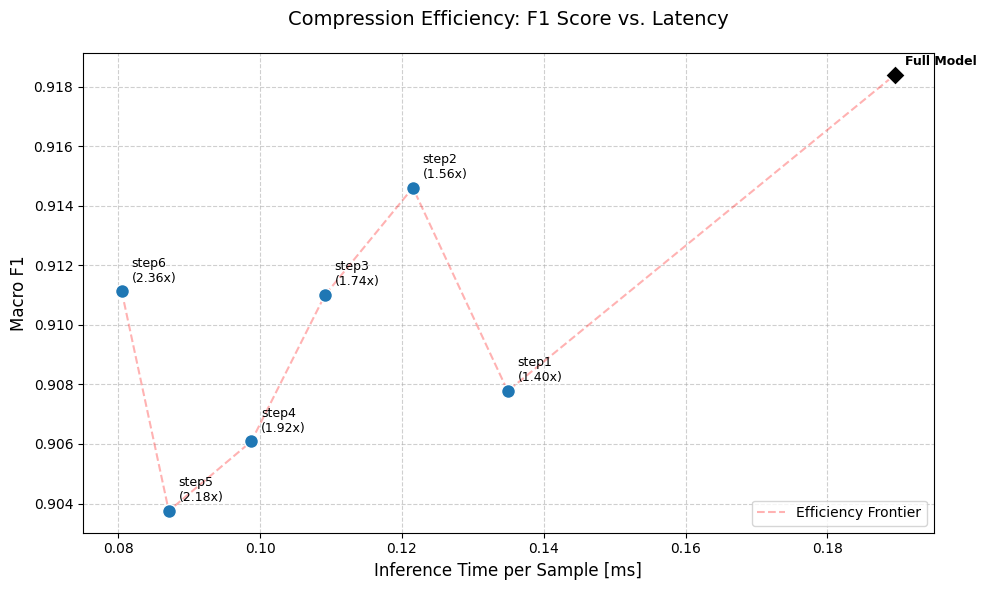

In [3]:
df = time_performance_compression1('iterativ_step', True, predict_on_dataset, preprocessed_dataset)

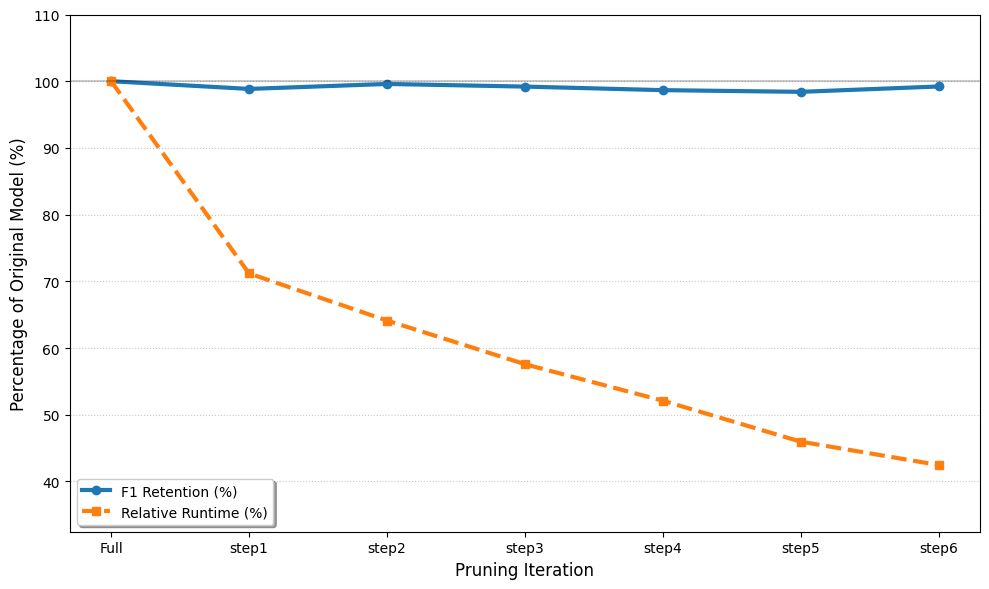

In [4]:
plot_percentage_trends(df)